In [19]:
import torch
!pip install pyro-ppl
import numpy as np
from sklearn.datasets import load_digits # only gives 8x8 (MNIST 784?)
import matplotlib.pyplot as plt

import pyro.distributions as dist
import pyro
from pyro.infer.autoguide import AutoDiagonalNormal, AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, TracePredictive, EmpiricalMarginal
from torch.distributions import constraints
from pyro import poutine

<Figure size 432x288 with 0 Axes>

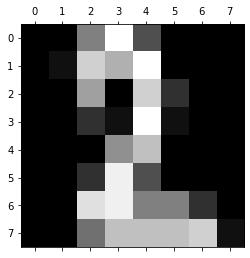

(1797, 8, 8)


In [13]:
digits = load_digits()
plt.gray()
plt.matshow(digits.images[22])
plt.show()

print (digits.images.shape)

In [28]:
K = 30  # truncate after 30 components
N = digits.images.shape[0]

data = torch.tensor([ k.flatten() for k in digits.images ])


def stick_breaking(beta):
  res = torch.cat([ torch.ones(1, dtype=torch.long), torch.cumprod(1 - beta, 0, dtype=torch.long)[:-1] ])
  return beta * res

@poutine.broadcast
def model(data):
  alpha = pyro.sample('alpha', dist.Gamma(1, 1))

  with pyro.iarange('mixture_components', K):
    beta = pyro.sample('beta', dist.Beta(1, alpha))
    tau = pyro.sample('tau', dist.Gamma(1, 1,))
    lambda_ = pyro.sample('lambda', dist.Uniform(0, 5))
    mu = pyro.sample('mu', dist.Normal(0, torch.rsqrt(lambda_ * tau)) )
  
  for n in pyro.iarange('observations', N):
    assignment = pyro.sample('assignment_{}'.format(str(n)), dist.Categorical(stick_breaking(beta)))
    pyro.sample("im_{}".format(str(n)), dist.Normal(mu[assignment], torch.rsqrt(lambda_ * tau)[assignment]), obs=data)

guide = AutoDelta(poutine.block(model, expose=['beta', 'tau', 'lambda_', 'mu']))
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=TraceEnum_ELBO(), num_samples=1000)

def train(num_iterations):
    pyro.clear_param_store()
    for j in range(num_iterations):
        loss = svi.step(data)
        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x)))

train(5000)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

ValueError: ignored